# YouTube Metadata Analysis
Here we go and analyze YouTube metadata as upload behaviour for example.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [241]:
%connect_info

{
  "shell_port": 46463,
  "iopub_port": 60121,
  "stdin_port": 43549,
  "control_port": 59401,
  "hb_port": 56719,
  "ip": "127.0.0.1",
  "key": "32d9b4a8-e9e4b2fa948c7f4246c16bf2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-8ba07766-1b43-4080-8483-c91ec9bc7228.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [242]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [388]:
import sqlite3
import pandas as pd
import isodate
import pytz

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)


data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')

cest = pytz.timezone("Europe/Berlin")
data['publishedAt'] = pd.to_datetime(data['publishedAt']).dt.tz_convert(cest)
data['updated'] = pd.to_datetime(data['updated']).dt.tz_convert(cest)

data['tags'] = data['tags'].apply(lambda x: x.split("'")[1::2])
data['duration'] = data['duration'].apply(lambda x: isodate.parse_duration(x).total_seconds())
data['faction'] = data['faction'].apply(lambda x: x == 'True')
data.loc[data.channelId == 'UC7TAA2WYlPfb6eDJCeX4u0w', 'faction'] = True

no_subs_ids = data['subtitle'].apply(lambda x: len(x) <= 10)
#data.loc[no_subs_ids, 'subtitle'] = data.loc[no_subs_ids, 'description']

data.set_index('videoId', inplace=True)

## Variables
### Dates and periods

In [389]:
from datetime import datetime as time, timedelta


bt_election = cest.localize(time.fromisoformat('2017-09-24')).replace(hour=8)
eu_election = cest.localize(time.fromisoformat('2019-05-26')).replace(hour=8)

bt_start = bt_election - timedelta(days=83)
eu_start = eu_election - timedelta(days=83)
bt_end = bt_election + timedelta(days=84)
eu_end = eu_election + timedelta(days=84)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_end)
bt_campaign_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_election)
eu_campaign_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_election)

corpus = data[bt_period|eu_period]
bt_corpus = data[bt_period]
eu_corpus = data[eu_period]

campaign_corpus = data[bt_campaign_period|eu_campaign_period]
bt_campaign_corpus = data[bt_campaign_period]
eu_campaign_corpus = data[eu_campaign_period]

### Parties, elections and states

In [390]:
parties = {'union': 'Union',
         'spd': 'SPD',
         'afd': 'AfD',
         'fdp': 'FDP',
         'linke': 'Die Linke',
         'grüne': 'Die Grünen'}

elections = ['bt', 'eu']
new_states = ['BB', 'MV', 'SN', 'ST', 'TH']
old_states = ['BW', 'BY', 'HB', 'HH', 'HE', 'NI', 'NW', 'RP', 'SL', 'SH']


### Colors

In [391]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Visualization

In [878]:
from matplotlib.ticker import MaxNLocator
from IPython.display import display_html
import matplotlib.patches as mpatches

def barplot(data, label):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);

    color_map = [colors[party] for party in parties]
    ax.bar(parties.values(), channel_count[parties.keys()], color=color_map, width=.8)
    return fig

def compare_fig(bt_data, eu_data, label, left=False):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties.values(), bt_data[parties.keys()], color=color_map_dark, width=-.4, align='edge', label='Bundestag election')
    ax.bar(parties.values(), eu_data[parties.keys()], color=color_map_light, width=.4, align='edge', label='European election')
    print_legend(ax, left)
    

    return fig

        
def display_side_by_side(*args):
    """ Displays mutiple panda DataFrames side by side.
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
    
def top_n(df, column, n):
    """ Sorts a pandas DataFrame and returns the first n entries of a specific column.
    """
    return df[[column]].sort_values(ascending=False, by=column).iloc[:n]

In [961]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def print_legend(ax, left=False):
    if left:
        label = ax.text(0.15, 0.9, 'Bundestag election\n European election', transform=ax.transAxes, fontsize=16)
    else:
        label = ax.text(0.74, 0.9, 'Bundestag election\n European election', transform=ax.transAxes, fontsize=16)
    ax.figure.canvas.draw()
    bbox = label.get_window_extent()
    bbox_data = ax.transData.inverted().transform(bbox) 
    text_x_left = bbox_data[0][0]
    text_x_right = bbox_data[1][0]
    text_y_bottom = bbox_data[0][1]
    text_y_top = bbox_data[1][1]

    text_width = text_x_right - text_x_left
    text_height = text_y_top - text_y_bottom

    patches_width = 0.5 * text_width
    x_box_border = 0.05 * text_width
    y_box_border = 0.05 * text_height

    box_width = patches_width + text_width + 2 * x_box_border
    box_height = text_height + 5 * y_box_border

    box_position = (text_x_left-patches_width-x_box_border, text_y_bottom - 2 * y_box_border)

    box = mpatches.Rectangle(box_position, box_width, box_height, fill=True, facecolor='white', edgecolor='black')
    ax.add_patch(box)

    num_patches = len(parties)
    patch_width = (patches_width - 2 * x_box_border)/num_patches
    patch_height = (box_height/2 - 4.5 * y_box_border)

    for num, party in enumerate(parties):
        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, fill=True, color=colors_light[party])
        ax.add_patch(patch)

        patch_x = box_position[0] + x_box_border + num * patch_width
        patch_y = box_position[1] + box_height - patch_height - 2.5 * y_box_border
        patch = mpatches.Rectangle((patch_x, patch_y), patch_width, patch_height, fill=True, color=colors[party])
        ax.add_patch(patch)

## Plotting

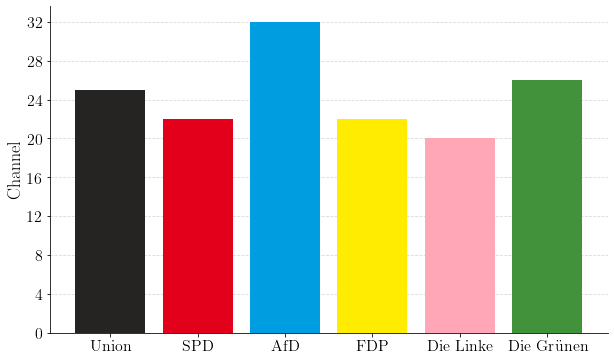

In [962]:
channel_count = corpus.groupby('party').nunique()['channelId']

fig = barplot(channel_count, 'Channel')
fig.savefig('outputs/channel-count.pdf', bbox_inches = 'tight', pad_inches = 0)

## Video count

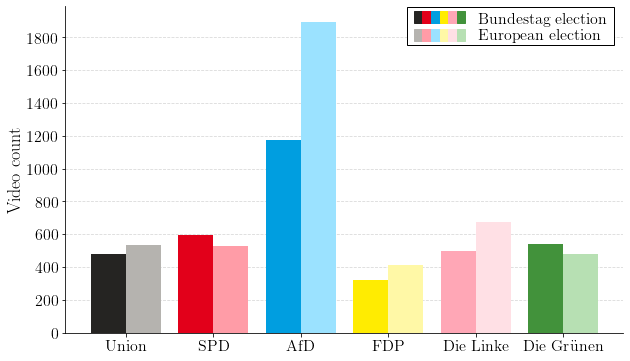

In [963]:
bt_video_count = bt_corpus.groupby('party')['title'].count()
eu_video_count = eu_corpus.groupby('party')['title'].count()

fig = compare_fig(bt_video_count, eu_video_count, 'Video count')
plt.savefig('outputs/yt-party-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

#### No faction videos

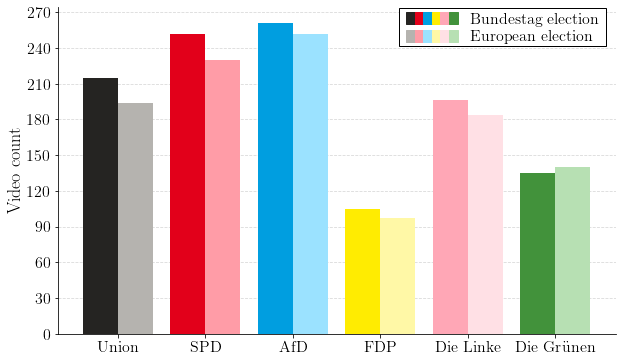

In [964]:
bt_video_count = bt_corpus[~bt_corpus.faction].groupby('party')['title'].count()
eu_video_count = eu_corpus[~eu_corpus.faction].groupby('party')['title'].count()

fig = compare_fig(bt_video_count, eu_video_count, 'Video count')
plt.savefig('outputs/yt-party-no-faction-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Only faction videos

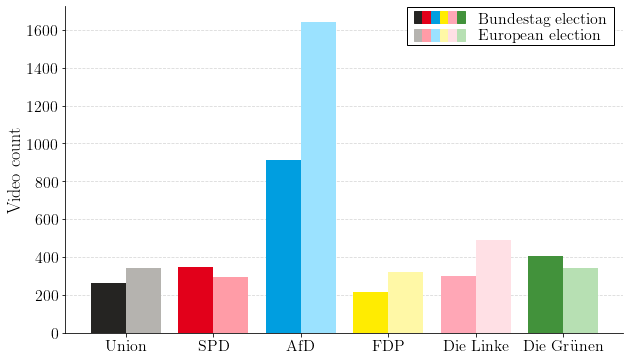

In [965]:
bt_video_count = bt_corpus[bt_corpus.faction].groupby('party')['title'].count()
eu_video_count = eu_corpus[eu_corpus.faction].groupby('party')['title'].count()

fig = compare_fig(bt_video_count, eu_video_count, 'Video count')
plt.savefig('outputs/yt-party-faction-video-count.pdf', bbox_inches = 'tight', pad_inches = 0)

## Video duration

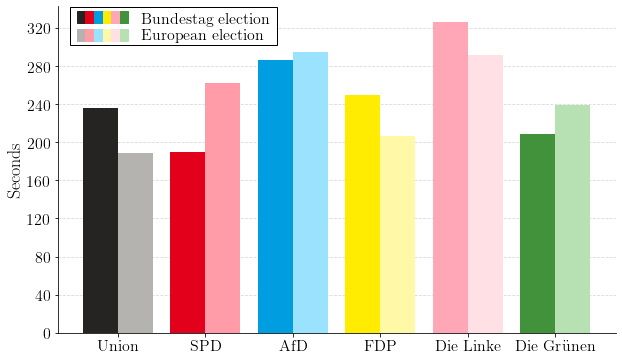

In [966]:
bt_video_length = bt_corpus.groupby('party')['duration'].median()
eu_video_length = eu_corpus.groupby('party')['duration'].median()

fig = compare_fig(bt_video_length, eu_video_length, 'Seconds', left=True)
plt.savefig('outputs/yt-party-duration.pdf', bbox_inches = 'tight', pad_inches = 0)

## Missing subtitles count

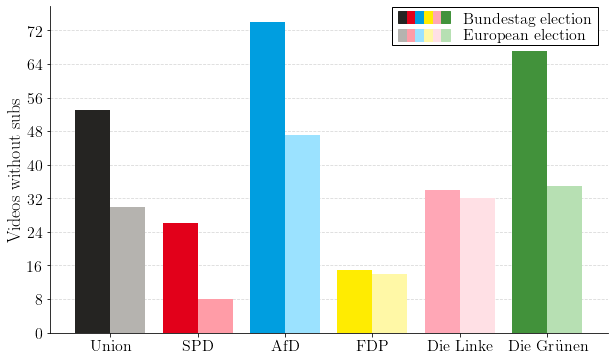

In [969]:
bt_msubtitle_count = bt_corpus.groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
eu_msubtitle_count = eu_corpus.groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
fig = compare_fig(bt_msubtitle_count, eu_msubtitle_count, 'Videos without subs')
fig.savefig('outputs/videos-without-subs-count.pdf', bbox_inches = 'tight', pad_inches = 0)

### Upload analysis

In [960]:
import matplotlib.dates as mdates

def plotHist(bt, eu, ylabel):
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharey=True)

    ind_bt = bt_upload_count.index
    ind_eu = eu_upload_count.index

    # Find week of election
    bt_election_idx = np.argmax(ind_bt[ind_bt <= (bt_election - timedelta(hours=8))])
    eu_election_idx = np.argmax(ind_eu[ind_eu <= (eu_election - timedelta(hours=8))])
    ax[0].axvline(x=bt_election_idx, c='black', linewidth=2, linestyle='dashed')
    ax[1].axvline(x=eu_election_idx, c='black', linewidth=2, linestyle='dashed')

    bt_bottom = [0] * len(ind_bt)
    eu_bottom = [0] * len(ind_eu)
    for party in parties:
        color = colors[party]
        label = party.upper()

        bt_values = bt.loc[ind_bt, party]
        eu_values = eu.loc[ind_eu, party]
        bt_values.plot.bar(ax=ax[0], bottom=bt_bottom, color=color, label=parties[party])
        eu_values.plot.bar(ax=ax[1], bottom=eu_bottom, color=color, label=parties[party])

        bt_heights = [p.get_height() for p in ax[0].patches]
        bt_bottom = [x + y for x, y in zip(bt_bottom, bt_heights[-len(ind_bt):])]
        eu_heights = [p.get_height() for p in ax[1].patches]
        eu_bottom = [x + y for x, y in zip(eu_bottom, eu_heights[-len(ind_eu):])]

    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)

    ticks = 3
    off = 2

    ax[0].set_xticks(ax[0].get_xticks()[off::ticks])
    ax[1].set_xticks(ax[1].get_xticks()[off::ticks])

    ax[0].xaxis.set_major_formatter(plt.FixedFormatter(ind_bt[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))
    ax[1].xaxis.set_major_formatter(plt.FixedFormatter(ind_eu[off::ticks].to_series(keep_tz=True).dt.strftime("%d %b")))

    plt.setp(ax[0].get_xticklabels(), rotation=0)
    plt.setp(ax[1].get_xticklabels(), rotation=0)

    ax[0].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax[1].grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')


    ax[0].axes.get_xaxis().get_label().set_visible(False)
    ax[1].axes.get_xaxis().get_label().set_visible(False)

    ax[0].set_ylabel(ylabel + ' BT', size=9)
    ax[1].set_ylabel(ylabel + ' EU', size=9)

    ax[0].legend(loc="upper left", prop={'size': 13}, ncol=6)

    plt.tight_layout()
    return fig

#### All videos

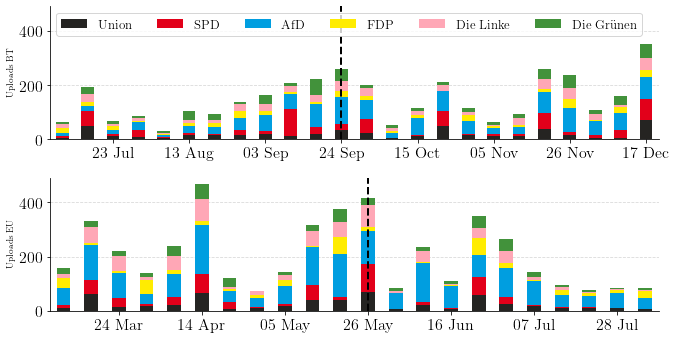

In [459]:
bt_upload_count = bt_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_upload_count = eu_corpus.groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plotHist(bt_upload_count, eu_upload_count, 'Uploads')
fig.savefig('outputs/yt-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### No faction videos

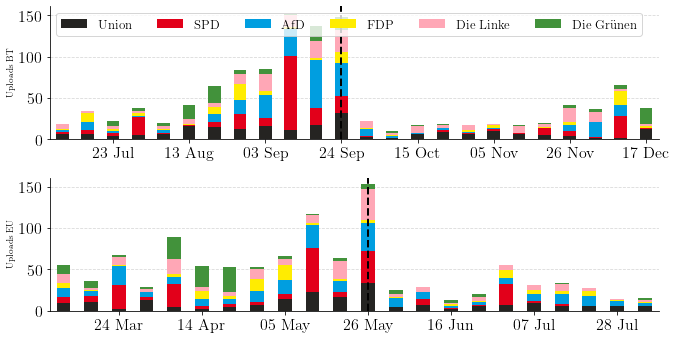

In [460]:
bt_nfaction_upload_count = bt_corpus[~bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_nfaction_upload_count = eu_corpus[~eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plotHist(bt_nfaction_upload_count, eu_nfaction_upload_count, 'Uploads')
fig.savefig('outputs/yt-no-faction-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Only faction videos

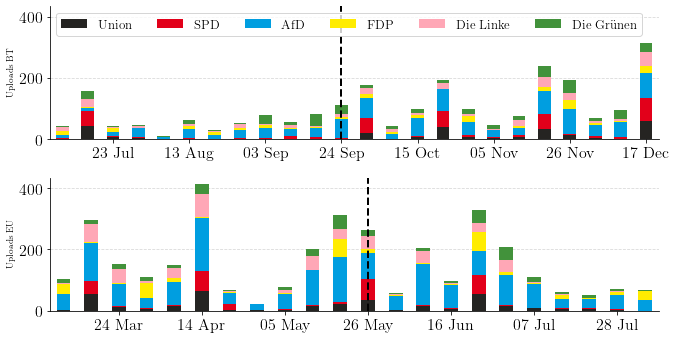

In [461]:
bt_nfaction_upload_count = bt_corpus[bt_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
eu_nfaction_upload_count = eu_corpus[eu_corpus.faction].groupby([pd.Grouper(key='publishedAt', freq='W', label='right'), 'party'])['title'].count().unstack()
fig = plotHist(bt_nfaction_upload_count, eu_nfaction_upload_count, 'Uploads')
fig.savefig('outputs/yt-faction-upload-count-analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

#### Average videos per channel

In [462]:
corpus.reset_index().groupby(['channelId', 'party']).count()['videoId'].groupby('party').mean()

party
afd      95.843750
fdp      33.318182
grüne    39.230769
linke    58.400000
spd      51.090909
union    40.520000
Name: videoId, dtype: float64

### Average Video Length

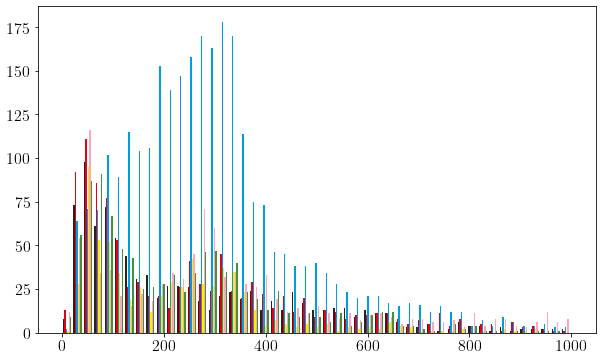

In [226]:
bins = np.linspace(0, 1000, 50)
for party in parties:
    #plt.axvline(durations.median(), color=colors[party])
    plt.hist([corpus[(corpus.party == party)]['duration'] for party in parties], bins, 
             histtype='bar', 
             color=[colors[party] for party in parties], 
             linewidth=2, 
             fill=True)

### View count analysis

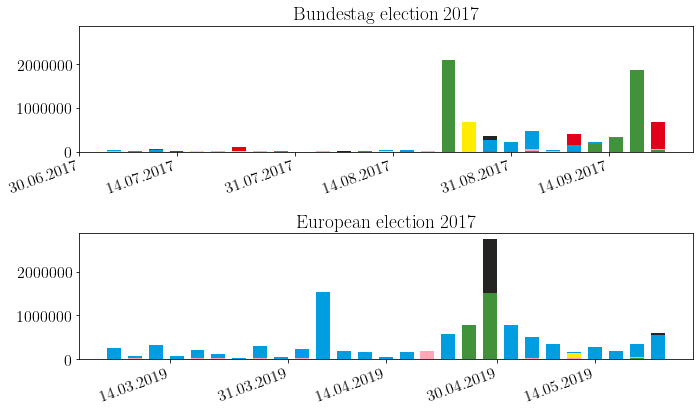

In [34]:
import matplotlib.dates as mdates

upload_count = data[bt_period|eu_period].groupby([pd.Grouper(key='publishedAt', freq='3d'), data['party']])['viewCount'].sum().unstack()
f, ax = plt.subplots(2,1, figsize=(10,6), sharey=True)
for ix,party in enumerate(parties):
    axL = ax[0]
    axR = ax[1]
#    if type(party) is list:
#        title = 'Uploads: ALL'
#        color = 'black'
#        uploads = upload_count[party].sum(axis=1)
#    else:
    title = party.upper()
    color = colors[party]
    uploads = upload_count[party]
    if ix == 0:
        axL.set_title('Bundestag election 2017', size='large')
        axR.set_title('European election 2017', size='large')
    #axL.axvline(x=bt_election, c='red')
    #axR.axvline(x=eu_election, c='red')
    #axL.annotate(" 24.09.2017", xy=(bt_election,.9), xycoords=("data", "axes fraction"))
    #axR.annotate(" 26.05.2019", xy=(eu_election,.9), xycoords=("data", "axes fraction"))
    #axL.set_ylabel(title, rotation=0, size='large', labelpad=50)
    axL.bar(x=uploads[bt_start:bt_election].index, height=uploads[bt_start:bt_election], color=color, width=2)
    axR.bar(x=uploads[eu_start:eu_election].index, height=uploads[eu_start:eu_election], color=color, width=2)
    axL.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    axR.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
    plt.setp(axL.get_xticklabels(), ha="right", rotation=20)
    plt.setp(axR.get_xticklabels(), ha="right", rotation=20)
    
plt.tight_layout()
fig.savefig('outputs/view-count_analysis.pdf', bbox_inches = 'tight', pad_inches = 0)

### Comment count analysis

In [ ]:
view_count = data.groupby([pd.Grouper(key='publishedAt', freq='3d'), data['party']])['commentCount'].sum().unstack()
f, ax = plt.subplots(len(parties)+1,2, figsize=(15,30), sharey='row')
for ix,party in enumerate(parties + [parties]):
    axL = ax[ix][0]
    axR = ax[ix][1]
    if type(party) is list:
        title = 'Views: ALL'
        color = 'black'
        views = view_count[party].sum(axis=1)
    else:
        title = 'Views: ' + party.upper()
        color = colors[party]
        views = view_count[party]
    if ix == 0:
        axL.set_title('Bundestag election 2017', size='large')
        axR.set_title('European election 2017', size='large')
    axL.axvline(x=bt_election, c='red')
    axR.axvline(x=eu_election, c='red')
    axL.annotate(" 24.09.2017", xy=(bt_election,.9), xycoords=("data", "axes fraction"))
    axR.annotate(" 26.05.2019", xy=(eu_election,.9), xycoords=("data", "axes fraction"))
    axL.set_ylabel(title, rotation=0, size='large', labelpad=50)
    views[bt_start:bt_end].plot(color=color, ax=axL)
    views[eu_start:eu_end].plot(color=color, ax=axR) 
    axL.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    axR.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))

In [ ]:
style = dict(size=10, color='gray')
plt.title("Uploads monthly")
count_month = data.groupby(data["publishedAt"].dt.to_period('W'))[
    'viewCount'].sum()
plt.annotate("National election", xy=('2017-09-24', 3000000),  xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), xytext=(60, -30), textcoords='offset points', ha='center', arrowprops=dict(arrowstyle="->"))
count_month.plot(color='black');

for party in parties:
    count_party_month = data[data['party'] == party].groupby([data["publishedAt"].dt.to_period('W'), data['party']])['viewCount'].sum().unstack()
    count_party_month.plot(color=colors[party])
    plt.title(party + ": View Count grouped by week")
    plt.axis([None, None, 0, 3000000])

In [ ]:
plt.title("Uploads weekly")
count_week = data.groupby(data["publishedAt"].dt.to_period('W'))[
    'title'].count()
count_week.plot(color='black')
# WEEKLY
plt.title("Uploads by party weekly")
count_party_week = data.groupby([data["publishedAt"].dt.week, data['party']])[
    'title'].count().unstack()
count_party_week.plot(color=count_party_week.apply(
    lambda x: colors[x.name]), kind='bar')

data[data['publishedAt'] > '10.10.2017']['publishedAt']

peak2 = data.query(
    'publishedAt > "10.10.2017" and publishedAt < "10.20.2017"').index
for title in data.loc[peak2]['title']:
    print(title)


In [ ]:
count = data.groupby([data["publishedAt"].dt.week, data['party']])['title'].count().unstack()
count.plot(color=count.apply(lambda x: colors[x.name]))

## ViewCount

In [ ]:
data.sort_values('viewCount')[['title', 'channelTitle','publishedAt','viewCount']]

## CommentCount

In [ ]:
data['publishedAt'] = pd.to_datetime(data['publishedAt']) 

In [ ]:
viewCount = data.groupby([data["publishedAt"].dt.month, data['party']]).sum()['viewCount'].unstack()
viewCount

In [ ]:
count = data.groupby([data["publishedAt"].dt.week, data['party']])['title'].count().unstack()
count.plot(color=count.apply(lambda x: colors[x.name]))

In [ ]:
count.sum()

In [ ]:
viewCount.plot(kind='bar', color=viewCount.apply(lambda x: colors[x.name]))

In [ ]:
data.columns

## Tags

In [ ]:
from itertools import chain
from collections import Counter

tags_by_party = {party: [tag.lower() for tag in chain(*data.loc[data['party'] == party, 'tags'])] for party in parties}
most_used_tags_by_party = {party: Counter(tags_by_party[party]) for party in parties}
most_used_tags_by_party = pd.DataFrame.from_dict(most_used_tags_by_party).fillna(0).astype(int)

In [ ]:
display_side_by_side(*(top_n(most_used_tags_by_party, party, 15) for party in parties))